In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import scipy
from scipy import sparse, fftpack, io as scio, integrate, signal
from scipy.sparse import linalg as splinalg
import time

In [ ]:
#from google.colab import files

#uploaded = files.upload()

Saving MRI_DATA.mat to MRI_DATA.mat


**1.1**

In [ ]:
def homogenous_dirichlet_fd_1d(grid_size, grid_spacing):
    return 1/grid_spacing**2 * sparse.diags([np.ones(grid_size - 1),
                                             -2 * np.ones(grid_size),
                                             np.ones(grid_size - 1)], [-1, 0, 1])

In [ ]:
def test_1d_dirichlet():
    grid_spacing = 0.01
    quad_coeff = np.random.uniform(-1, 1)
    x = np.arange(start=-1, stop=1, step=grid_spacing)
    y = quad_coeff * np.power(x, 2)
    fd_mat = homogenous_dirichlet_fd_1d(len(x), grid_spacing)
    deriv = fd_mat.dot(y)
    np.testing.assert_allclose(deriv[1:-1], 2 * quad_coeff)
    y_pad = np.pad(y, (1, 1))
    fd_mat_pad = homogenous_dirichlet_fd_1d(len(y_pad), grid_spacing)
    deriv_pad = fd_mat_pad.dot(y_pad)[1:-1]
    np.testing.assert_allclose(deriv_pad, deriv)


In [ ]:
test_1d_dirichlet()

In [ ]:
def homogenous_dirichlet_fd_2d(grid_size, grid_spacing):
    fd_mat = homogenous_dirichlet_fd_1d(grid_size, grid_spacing)
    return sparse.kron(fd_mat, sparse.identity(grid_size)) + sparse.kron(sparse.identity(grid_size), fd_mat)


In [ ]:
def test_2d_dirichlet():
    grid_spacing = 0.01
    quad_coeff_x = np.random.uniform(-1, 1)
    quad_coeff_y = np.random.uniform(-1, 1)
    grid_side = np.arange(start=-1, stop=1, step=grid_spacing)
    x_grid, y_grid = np.meshgrid(grid_side, grid_side)
    f = quad_coeff_x * x_grid**2 + quad_coeff_y * y_grid**2
    fd_mat = homogenous_dirichlet_fd_2d(len(grid_side), grid_spacing)
    deriv = np.reshape(fd_mat.dot(f.flatten()), np.shape(f))
    np.testing.assert_allclose(deriv[1:-1, 1:-1], 2 * (quad_coeff_x + quad_coeff_y))
    f_pad = np.pad(f, ((1, 1), ))
    fd_mat_pad = homogenous_dirichlet_fd_2d(np.shape(f_pad)[0], grid_spacing)
    deriv_pad = np.reshape(fd_mat_pad.dot(f_pad.flatten()), np.shape(f_pad))[1:-1, 1:-1]
    np.testing.assert_allclose(deriv_pad, deriv)

In [ ]:
test_2d_dirichlet()

In [ ]:
def compute_k_sq(f):
  omega = 2 * np.pi * f
  return omega**2/(3e8)**2

In [ ]:
def construct_direct_fd_const_coeff(grid_size, grid_spacing, k_sq):
    return homogenous_dirichlet_fd_2d(grid_size, grid_spacing) \
           + sparse.diags([np.ones(grid_size * grid_size) * k_sq], [0])

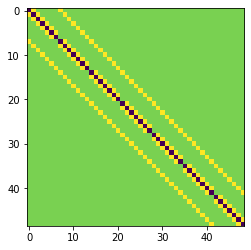

In [ ]:
f = 21.3e6
k_sq = compute_k_sq(f)
grid_spacing = 1/8
grid = np.arange(start=0, stop=1 + grid_spacing, step=grid_spacing)
grid_nonzero = grid[1:-1]
helm_mat = construct_direct_fd_const_coeff(len(grid_nonzero), grid_spacing, k_sq)

helm_mat_dense = np.array(helm_mat.todense())
plt.imshow(helm_mat_dense)
plt.show()

The matrix has a banded structure. The 3 inner bands come from the diagonal potential term and the FD operator of the form $I \otimes K$. The two inner bands come from the operator $K \otimes I$.

**1.2**

In [ ]:
def gaussian_2d(x_grid, y_grid, center_x, center_y, sigma):
    return 1/np.sqrt((2 * np.pi)**2 * sigma**4) * np.exp(-1/2 * ((x_grid - center_x)/sigma)**2) * np.exp(-1/2 * ((y_grid - center_y)/sigma)**2)


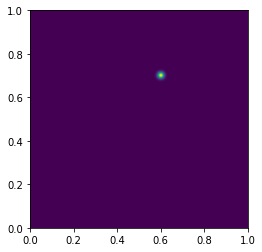

In [ ]:
grid_spacing = 1/256
grid = np.arange(start=0, stop=1 + grid_spacing, step=grid_spacing)
grid_free = grid[1:-1]
x_grid, y_grid = np.meshgrid(grid_free, grid_free)

center_x = 0.6
center_y = 0.7
sigma = 0.01
v = gaussian_2d(x_grid, y_grid, center_x, center_y, sigma)
v_fig, v_axs = plt.subplots(nrows=1, ncols=1)
v_axs.imshow(v, origin="lower", extent=(0, 1, 0, 1))
plt.show()

In [ ]:
def solve_direct_fd_const_coeff(grid_spacing, k_sq, v):
    grid_size = np.shape(v)[0]
    return np.reshape(splinalg.spsolve(construct_direct_fd_const_coeff(grid_size, grid_spacing, k_sq), v.flatten()), v.shape)



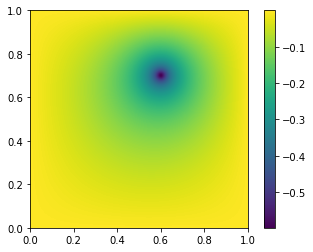

In [ ]:
f = 21.3e6
k_sq = compute_k_sq(f)
soln_direct_low = solve_direct_fd_const_coeff(grid_spacing, k_sq, v)
soln_fig, soln_axs = plt.subplots(nrows=1, ncols=1)
im = soln_axs.imshow(soln_direct_low, origin="lower", extent=(0, 1, 0, 1))
soln_fig.colorbar(im, orientation='vertical')
plt.show()

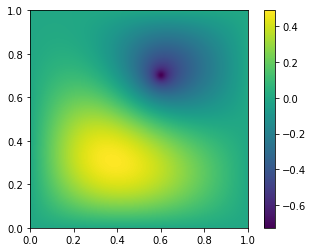

In [ ]:
f = 298.3e6
k_sq = compute_k_sq(f)
soln_direct_high = solve_direct_fd_const_coeff(grid_spacing, k_sq, v)
soln_fig, soln_axs = plt.subplots(nrows=1, ncols=1)
im = soln_axs.imshow(soln_direct_high, origin="lower", extent=(0, 1, 0, 1))
soln_fig.colorbar(im, orientation='vertical')
plt.show()

**1.3**

In [ ]:
def dst_1(signal, axis=-1):
    N = signal.shape[axis]
    return fftpack.dst(signal, type=1, axis=axis)/N

In [ ]:
def idst_1(signal, axis=-1):
    N = signal.shape[axis]
    return N/(2 * (N+1)) * fftpack.dst(signal, type=1, axis=axis)

In [ ]:
def test_inverse():
    signal = np.random.uniform(-1, 1, 50)
    forward = dst_1(signal)
    backward = idst_1(forward)
    np.testing.assert_allclose(backward, signal)

In [ ]:
test_inverse()

In [ ]:
def solve_precond_const_coeff(grid_spacing, k_sq, v):
    N = np.shape(v)[0] + 1
    v_freq = dst_1(dst_1(v, axis=1), axis=0).flatten()
    k_vals = np.arange(start=1, stop=N, step=1)
    lambda_vals = -1 * (2 - 2 * np.cos(np.pi * k_vals/N))
    lhs = 1/grid_spacing**2 * (np.kron(lambda_vals, np.ones(np.shape(v)[0])) +
                               np.kron(np.ones(np.shape(v)[0]), lambda_vals)) + k_sq
    soln_freq = v_freq/lhs
    return idst_1(idst_1(np.reshape(soln_freq, np.shape(v)), axis=1), axis=0)


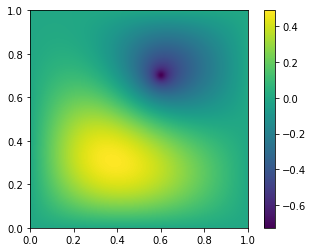

In [ ]:
f = 298.3e6
k_sq = compute_k_sq(f)
soln_precond_high = solve_precond_const_coeff(grid_spacing, k_sq, v)
soln_fig, soln_axs = plt.subplots(nrows=1, ncols=1)
im = soln_axs.imshow(soln_precond_high, origin="lower", extent=(0, 1, 0, 1))
soln_fig.colorbar(im, orientation='vertical')
plt.show()


In [ ]:
error = np.max(np.abs(soln_precond_high - soln_direct_high))/np.max(np.abs(soln_direct_high))
print(error)

8.071829229513951e-13


The two solvers give the same answer. They better, as they are nominally performing the same computation, just in a different basis.

**1.4**

2.63 ms ± 56.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
166 µs ± 1.68 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
6.14 ms ± 38.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
212 µs ± 5.41 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
20.2 ms ± 616 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
376 µs ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
131 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1 ms ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
715 ms ± 7.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.72 ms ± 64.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.45 s ± 61.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
22.5 ms ± 238 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
28.9 s ± 507 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
90.6 ms ± 782 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


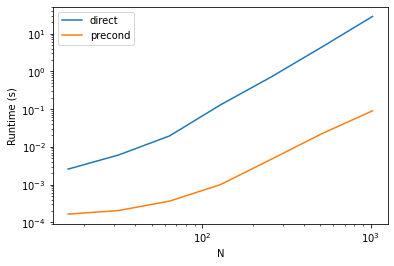

In [ ]:
f = 298.3e6
k_sq = compute_k_sq(f)
N_vals = 2 ** np.arange(start=4, stop=11, step=1)
all_t_direct = []
all_t_precond = []
for N in N_vals:
  grid_spacing = 1/N
  grid = np.arange(start=0, stop=1 + grid_spacing, step=grid_spacing)
  grid_free = grid[1:-1]
  x_grid, y_grid = np.meshgrid(grid_free, grid_free)
  v = gaussian_2d(x_grid, y_grid, center_x, center_y, sigma)
  t_direct = %timeit -o solve_direct_fd_const_coeff(grid_spacing, k_sq, v)
  t_precond = %timeit -o solve_precond_const_coeff(grid_spacing, k_sq, v)
  all_t_direct.append(t_direct.best)
  all_t_precond.append(t_precond.best)
time_fig, time_axs = plt.subplots(nrows=1, ncols=1)
time_axs.set_yscale("log")
time_axs.set_xscale("log")
time_axs.set_ylabel("Runtime (s)")
time_axs.set_xlabel("N")
time_axs.plot(N_vals, all_t_direct, label="direct")
time_axs.plot(N_vals, all_t_precond, label="precond")
time_axs.legend()
plt.show()

We can see that the direct solver is scaling roughly with $N^3$. This is expected, as a dense Cholskey decomposition scales as with N^3, however we probably see a small benefit from the sparsity. The preconditioned solver scales more like $N^2$, as expected from the FFT complexity. 

**2.1**

These new matricies are not diagonalizable by the DST, as the potential matrix is no longer perportionate to the identity, so it will not commute with the DST.

In [ ]:
def construct_direct_fd_variable_k(grid_spacing, k_sq):
    grid_size = np.shape(k_sq)[0]
    return homogenous_dirichlet_fd_2d(grid_size, grid_spacing) \
           + sparse.diags([k_sq.flatten()], [0])

In [ ]:
def solve_direct_fd_variable_k(grid_spacing, k_sq, v):
    return np.reshape(splinalg.spsolve(construct_direct_fd_variable_k(grid_spacing, k_sq), v.flatten()), v.shape)


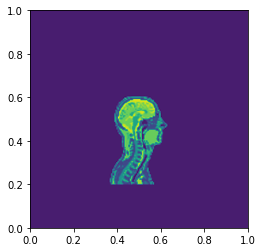

In [ ]:
data = scio.loadmat("MRI_DATA.mat")
eps = np.flipud(data["e_r"][1:-1, 1:-1])
fig, axs = plt.subplots(nrows=1, ncols=1)
axs.imshow(np.real(eps), origin="lower", extent=(0, 1, 0, 1))

In [ ]:
grid_spacing = 1/256
grid = np.arange(start=0, stop=1 + grid_spacing, step=grid_spacing)
grid_free = grid[1:-1]
x_grid, y_grid = np.meshgrid(grid_free, grid_free)
center_x = 0.5
center_y = 0.5
sigma = 0.01
v = gaussian_2d(x_grid, y_grid, center_x, center_y, sigma)
xlims = [0.35, 0.635]
ylims = [0.186, 0.629]

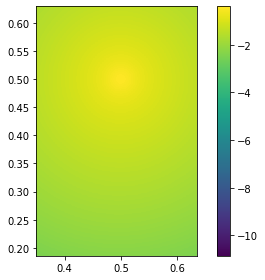

In [ ]:

f = 21.3e6
k_sq = compute_k_sq(f)
start_time = time.time()
soln_direct_var_k_low = solve_direct_fd_variable_k(grid_spacing, k_sq * eps, v)
end_time = time.time()
direct_var_k_time = end_time - start_time
soln_fig, soln_axs = plt.subplots(nrows=1, ncols=1)
im1 = soln_axs.imshow(np.log(np.abs(soln_direct_var_k_low)), origin="lower", extent=(0, 1, 0, 1))
soln_axs.set_xlim(xlims)
soln_axs.set_ylim(ylims)
soln_fig.colorbar(im1, ax=soln_axs)
soln_fig.tight_layout()
plt.show()

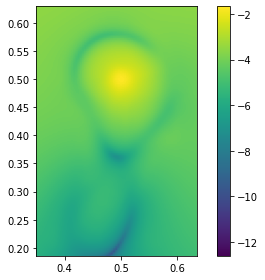

In [ ]:
f = 298.3e6
k_sq = compute_k_sq(f)
soln_direct_var_k_high = solve_direct_fd_variable_k(grid_spacing, k_sq * eps, v)
soln_fig, soln_axs = plt.subplots(nrows=1, ncols=1)
im1 = soln_axs.imshow(np.log(np.abs(soln_direct_var_k_high)), origin="lower", extent=(0, 1, 0, 1))
soln_axs.set_xlim(xlims)
soln_axs.set_ylim(ylims)
soln_fig.colorbar(im1, ax=soln_axs)
soln_fig.tight_layout()
plt.show()

**2.2**

In [ ]:
def run_iteration_variable_k(grid_spacing, k_sq, k_sq_0, v, u_prev, alpha=1):
    rhs = v - alpha * (k_sq - k_sq_0) * u_prev
    return solve_precond_const_coeff(grid_spacing, k_sq_0, rhs)

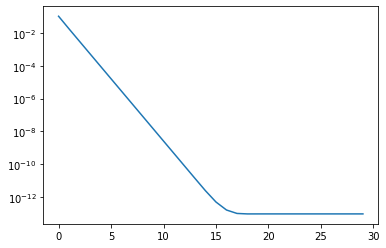

In [ ]:
f = 21.3e6
k_sq = compute_k_sq(f)
fig, axs = plt.subplots(nrows=1, ncols=1)
new_state = np.zeros_like(soln_direct_var_k_low)
deltas = []
for _ in range(30):
    new_state = run_iteration_variable_k(grid_spacing, k_sq * eps, k_sq, v, new_state)
    deltas.append(np.max(np.abs(new_state - soln_direct_var_k_low))/np.max(np.abs(soln_direct_var_k_low)))
axs.plot(deltas, label="f = {}".format(f))
axs.set_yscale("log")
plt.show()

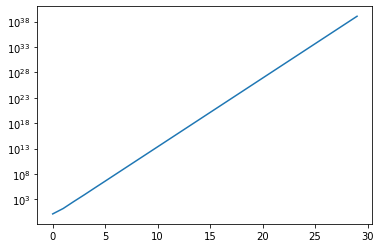

In [ ]:
f = 298.3e6
k_sq = compute_k_sq(f)
fig, axs = plt.subplots(nrows=1, ncols=1)
new_state = np.zeros_like(soln_direct_var_k_high)
deltas = []
for _ in range(30):
    new_state = run_iteration_variable_k(grid_spacing, k_sq * eps, k_sq, v, new_state)
    deltas.append(np.max(np.abs(new_state - soln_direct_var_k_high))/np.max(np.abs(soln_direct_var_k_high)))
axs.plot(deltas, label="f = {}".format(f))
axs.set_yscale("log")
plt.show()

The convergence of the iteration seems to depend strongly on frequency. The iteration does not converge at all for 298.3 MHz.

**2.3**

In [ ]:
f = 21.3e6
k_sq = compute_k_sq(f)
new_state = np.zeros_like(soln_direct_var_k_low)
deltas = []
start_time = time.time()
for _ in range(17):
    new_state = run_iteration_variable_k(grid_spacing, k_sq * eps, k_sq, v, new_state)
    deltas.append(np.max(np.abs(new_state - soln_direct_var_k_low))/np.max(np.abs(soln_direct_var_k_low)))
end_time = time.time()
print(end_time - start_time)
print(direct_var_k_time)

0.35446691513061523
1.1963145732879639


It seems the iteration is faster

**2.4**

$(\nabla^2 + k_0^2) u^{l+1} = v(r) - (k^2(r) - k_0^2) u^l$

$(\nabla^2 + k_0^2) \delta u^{l+1} + (\nabla^2 + k_0^2) \bar{u} = v(r) - (k^2(r) - k_0^2) \delta u^l - (k^2 (r) - k_0^2)\bar{u} $

$(\nabla^2 + k_0^2) \delta u^{l+1} + (\nabla^2 + k(r)^2) \bar{u} = v(r) - (k^2(r) - k_0^2) \delta u^l  $

But $(\nabla^2 + k(r)^2) \bar{u}  = v(r)$, so, 

$\delta u^{l+1} =  (\nabla^2 + k_0^2)^{-1}(k_0^2 - k^2(r)) \delta u^l$

This will converge if the eigenvalues of $(\nabla^2 + k_0^2)^{-1}(k_0^2 - k^2(r))$ all have norm less than 1.

The discussion here is useful: https://math.stackexchange.com/questions/1193763/eigenvalues-of-product-matrix

Let,

$A = (\nabla^2 + k_0^2)^{-1}$

$B = (k_0^2 - k^2(r))$

From the above discussion i know that that,

$|\lambda_{AB}^{max}| \leq |\lambda_{A}^{max}||\lambda_{B}^{max}|$

Since $B$ is diagonal, 

$\lambda_{B}^{max} = \max_r{|k_0^2 - k^2(r)|}$

We also know the eigenvalues of $A$, as a function of the indicies $k_1$ and $k_2$,

$\lambda_A = \frac{1}{\frac{4}{h^2} (\cos{(\frac{\pi k_1}{N})} - 1)(\cos{(\frac{\pi k_2}{N})} - 1) + k_0^2}$

So we can say for sure that the iteration will converge if,

$\max_{k_1, k_2}{|\frac{1}{\frac{4}{h^2} (\cos{(\frac{\pi k_1}{N})} - 1)(\cos{(\frac{\pi k_2}{N})} - 1) + k_0^2}|}\max_r{|k_0^2 - k^2(r)|} < 1$

Since the signs are different in the denominator of the first expression I don't think I can simplify it any further without knowing $k_0^2$, but I might be wrong about that.





**3.1**



In [ ]:
def dst_1_physical(signal, axis=-1):
    N = signal.shape[axis]
    return np.pi/(2 * (N+1)) * fftpack.dst(signal, type=1, axis=axis)

def idst_1_physical(signal, axis=-1):
    return 1/np.pi * fftpack.dst(signal, type=1, axis=axis)

In [ ]:
def test_physical_inverse():
    signal = np.random.uniform(-1, 1, 50)
    forward = dst_1_physical(signal)
    backward = idst_1_physical(forward)
    np.testing.assert_allclose(backward, signal)


def test_physical_normalization():
    def true_f(x):
        return x**2

    def true_integrand(x, k):
        return true_f(x) * np.sin((k+1) * x)

    k=3
    true_result = integrate.quad(lambda x: true_integrand(x, k), 0, np.pi)
    grid = np.arange(start=0, stop=np.pi, step=0.0001)
    f_grid = true_f(grid)
    dst_result = dst_1_physical(f_grid)
    np.testing.assert_allclose(true_result[0], dst_result[k], rtol=1e-5)


In [ ]:
test_physical_inverse()
test_physical_normalization()

In [ ]:
def spectral_solver(N, k_sq, v):
    k_vals = np.arange(start=0, stop=N, step=1)
    lhs = np.pi**2 * (np.kron(-(k_vals + 1)**2, np.ones(N)) +
                               np.kron(np.ones(N), -(k_vals + 1)**2)) + k_sq
    v_freq = dst_1_physical(dst_1_physical(v, axis=1), axis=0)
    red_v_freq = v_freq[:N, :N]
    soln_freq = np.reshape(red_v_freq.flatten() / lhs, red_v_freq.shape)
    return idst_1_physical(idst_1_physical(soln_freq, axis=1), axis=0)

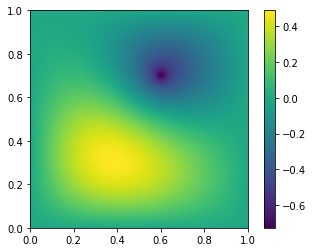

In [ ]:
n_modes = 512
grid_spacing = 1/n_modes
grid = np.arange(start=0, stop=1 + grid_spacing, step=grid_spacing)
grid_free = grid[1:-1]
x_grid, y_grid = np.meshgrid(grid_free, grid_free)

center_x = 0.6
center_y = 0.7
sigma = 0.01
v = gaussian_2d(x_grid, y_grid, center_x, center_y, sigma)

f = 298.3e6
k_sq = compute_k_sq(f)

soln_spectral_512 = spectral_solver(n_modes-1, k_sq, v)
soln_fig, soln_axs = plt.subplots(nrows=1, ncols=1)
im = soln_axs.imshow(soln_spectral_512, origin="lower", extent=(0, 1, 0, 1))
soln_fig.colorbar(im, orientation='vertical')

plt.show()

The result is the same as my FD solver.

**3.2**

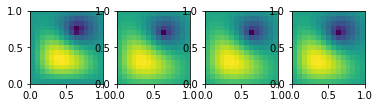

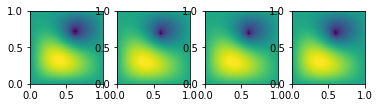

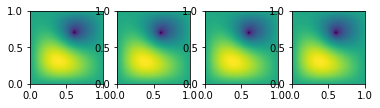

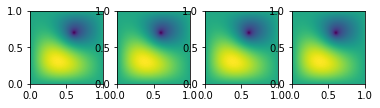

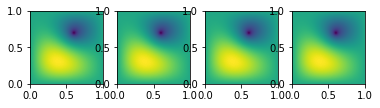

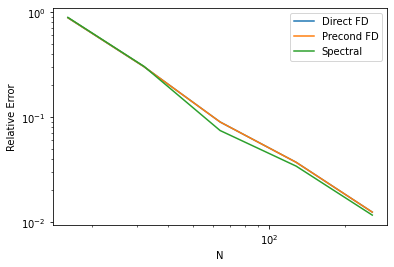

In [ ]:
f = 298.3e6
k_sq = compute_k_sq(f)
N_vals = 2 ** np.arange(start=4, stop=9, step=1)
direct_errors = []
precond_errors = []
spectral_errors = []
center_x = 0.6  
center_y = 0.7
sigma = 0.01
for N in N_vals:
  grid_spacing = 1/N
  grid = np.arange(start=0, stop=1 + grid_spacing, step=grid_spacing)
  grid_free = grid[1:-1]
  x_grid, y_grid = np.meshgrid(grid_free, grid_free)
  v = gaussian_2d(x_grid, y_grid, center_x, center_y, sigma)
  soln_fd_direct = solve_direct_fd_const_coeff(grid_spacing, k_sq, v)
  soln_fd_precond = solve_precond_const_coeff(grid_spacing, k_sq, v)
  soln_spectral = spectral_solver(N-1, k_sq, v)
  reduced_spectral_soln = signal.resample(signal.resample(soln_spectral_512, N-1, axis=0), N-1, axis=1)
  direct_errors.append(np.max(np.abs(soln_fd_direct - reduced_spectral_soln))/np.max(np.abs(reduced_spectral_soln)))
  precond_errors.append(np.max(np.abs(soln_fd_precond - reduced_spectral_soln))/np.max(np.abs(reduced_spectral_soln)))
  spectral_errors.append(np.max(np.abs(soln_spectral - reduced_spectral_soln))/np.max(np.abs(reduced_spectral_soln)))
  fig, axs = plt.subplots(ncols=4)
  axs[0].imshow(reduced_spectral_soln, origin="lower", extent=(0, 1, 0, 1))
  axs[1].imshow(soln_fd_direct, origin="lower", extent=(0, 1, 0, 1))
  axs[2].imshow(soln_fd_precond, origin="lower", extent=(0, 1, 0, 1))
  axs[3].imshow(soln_spectral, origin="lower", extent=(0, 1, 0, 1))

error_fig, error_axs = plt.subplots()
error_axs.plot(N_vals, direct_errors, label="Direct FD")
error_axs.plot(N_vals, precond_errors, label="Precond FD")
error_axs.plot(N_vals, spectral_errors, label="Spectral")
error_axs.set_xscale("log")
error_axs.set_yscale("log")
error_axs.set_xlabel("N")
error_axs.set_ylabel("Relative Error")
error_axs.legend()




The spectral solver always does a little better than the FD solvers, but I think the error should be scaling down faster in theory. The issue is probably that there is no "correct" way to downsample a signal without adding error, which is probably starting to dominate the results at large N.

**3.3**

In [ ]:
direct_times = []
precond_times = []
spectral_times = []
for N in N_vals:
  grid_spacing = 1/N
  grid = np.arange(start=0, stop=1 + grid_spacing, step=grid_spacing)
  grid_free = grid[1:-1]
  x_grid, y_grid = np.meshgrid(grid_free, grid_free)
  center_x = 0.6  
  center_y = 0.7
  sigma = 0.01
  v = gaussian_2d(x_grid, y_grid, center_x, center_y, sigma)
  t_direct = %timeit -o solve_direct_fd_const_coeff(grid_spacing, k_sq, v)
  t_precond = %timeit -o  solve_precond_const_coeff(grid_spacing, k_sq, v)
  t_spectral = %timeit -o spectral_solver(N-1, k_sq, v)
  reduced_spectral_soln = signal.resample(signal.resample(soln_spectral_512, N-1, axis=0), N-1, axis=1)
  direct_times.append(t_direct.best)
  precond_times.append(t_precond.best)
  spectral_times.append(t_spectral.best)


3.31 ms ± 995 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
162 µs ± 1.48 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
164 µs ± 19.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.14 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
213 µs ± 7.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
201 µs ± 6.97 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
41 ms ± 737 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
373 µs ± 9.39 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
359 µs ± 7.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
181 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
999 µs ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
986 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
752 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.74 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.9 

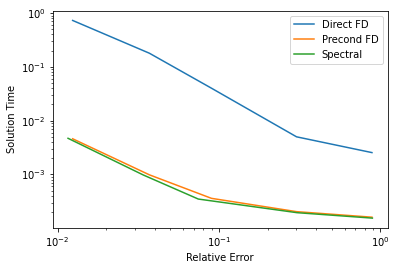

In [ ]:

time_fig, time_axs = plt.subplots()
time_axs.plot(direct_errors, direct_times, label="Direct FD")
time_axs.plot(precond_errors, precond_times, label="Precond FD")
time_axs.plot(spectral_errors, spectral_times, label="Spectral")
time_axs.set_xscale("log")
time_axs.set_yscale("log")
time_axs.set_xlabel("Relative Error")
time_axs.set_ylabel("Solution Time")
time_axs.legend()


Based on my calculations, the spectral and preconditioned solvers seem to perform similarly. I don't know if this is an artifact of the resampling of the solution or real. In theory I think the spectral solver should be dominant everywhere.

Although, it might actually make sense that the FD and spectral schemes have about the same accuracy. In class we showed that the two schemes produce more or less the same eigenvalues for small k, and the solution here is very smooth, so the error in the higher frequency modes encurred by the FD solver might not matter.